## importing libraries

In [52]:
import random
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## fetch the dataset

In [16]:
# Load dataset
file_path = '/content/Movies.csv'
movies_data = pd.read_csv(file_path)
movies_data.head()

,id,title,genres,language,user_score,runtime_hour,runtime_min,release_date,vote_count
0,1,The Shawshank Redemption,"Drama, Crime",en,8.7,2,22,1994-09-23,27070
1,2,The Godfather,"Drama, Crime",en,8.7,2,55,1972-03-14,20563
2,3,The Godfather Part II,"Drama, Crime",en,8.6,3,22,1974-12-20,12403
3,4,Schindler's List,"Drama, History, War",en,8.6,3,15,1993-12-15,15810
4,5,12 Angry Men,Drama,en,8.5,1,37,1957-04-10,8611


## Feature Engineering


In [17]:
# runtime_hour + runtime_min  = runtime
movies_data['runtime'] = movies_data['runtime_hour'] * 60 + movies_data['runtime_min']

In [18]:
# drop em shit
movies_cleaned = movies_data.drop(columns=['id', 'runtime_hour', 'runtime_min'])

In [19]:
# modifying date to year only
movies_cleaned['release_year'] = pd.to_datetime(movies_cleaned['release_date']).dt.year
movies_cleaned = movies_cleaned.drop(columns=['release_date'])

In [20]:
# encode them genres using MultiLabelBinarizer
movies_cleaned['genres'] = movies_cleaned['genres'].str.split(', ')
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies_cleaned['genres'])
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

## plots


<ipython-input-36-069e6e4c9a0a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


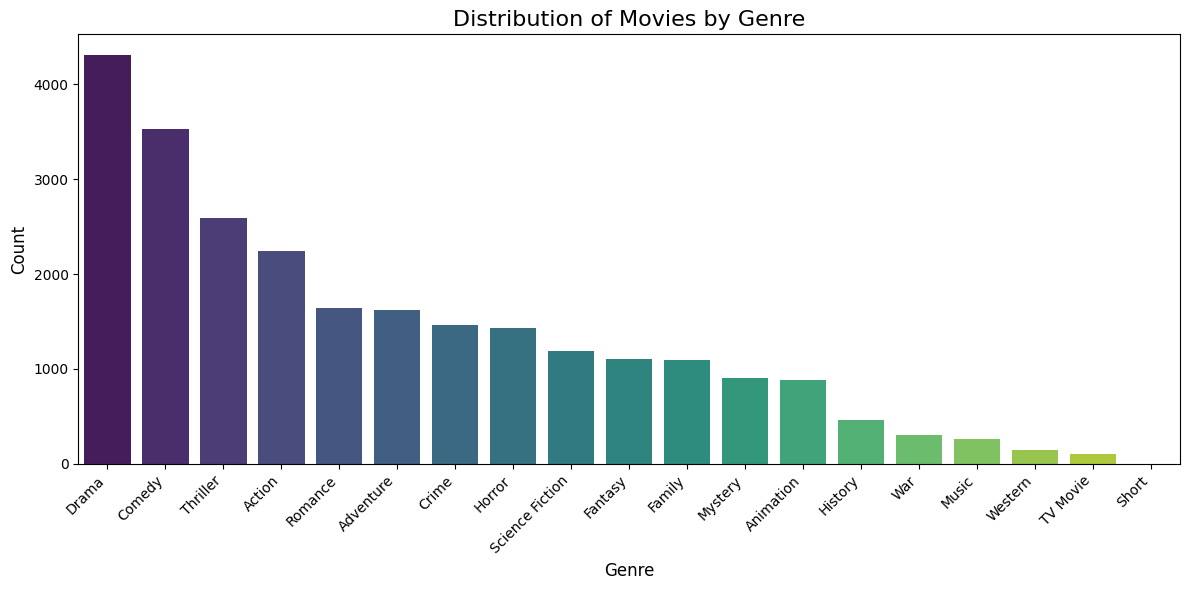

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

genre_counts = genres_df.sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
ax.set_title("Distribution of Movies by Genre", fontsize=16)
ax.set_xlabel("Genre", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [89]:
# append the encoded info to the dataset
movies_prepared = pd.concat([movies_cleaned.drop(columns=['genres']), genres_df], axis=1)
movies_prepared.head()

,title,language,user_score,vote_count,runtime,release_year,Action,Adventure,Animation,Comedy,...,Horror,Music,Mystery,Romance,Science Fiction,Short,TV Movie,Thriller,War,Western
0,The Shawshank Redemption,en,8.7,27070,142,1994,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Godfather,en,8.7,20563,175,1972,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Godfather Part II,en,8.6,12403,202,1974,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Schindler's List,en,8.6,15810,195,1993,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,12 Angry Men,en,8.5,8611,97,1957,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## train and test datasets


In [106]:
# features and target variable
X = movies_prepared.drop(columns=['title', 'language', 'user_score', 'release_year'])
y = movies_prepared['user_score']

In [107]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Model Building

In [108]:
def eval_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Model Mean Absolute Error: {mae:.2f}")
    print(f"Model Mean Squared Error: {mse:.2f}")

    return model

## model analysis

In [45]:
eval_model(LinearRegression())

Model Mean Absolute Error: 0.50
Model Mean Squared Error: 0.42


In [46]:
eval_model(DecisionTreeRegressor())

Model Mean Absolute Error: 0.67
Model Mean Squared Error: 0.76


In [47]:
eval_model(RandomForestRegressor())

Model Mean Absolute Error: 0.50
Model Mean Squared Error: 0.41


In [53]:
eval_model(XGBRegressor(objective='reg:squarederror'))

Model Mean Absolute Error: 0.50
Model Mean Squared Error: 0.41


In [109]:
model = eval_model(GradientBoostingRegressor())

Model Mean Absolute Error: 0.48
Model Mean Squared Error: 0.39


## user-given input

In [110]:
def recommend_movie(input_genres):
    # Validate input
    if not input_genres or not all(isinstance(genre, str) for genre in input_genres):
        return ["Invalid genre input.", None]

    # Encode user-input genres using the same MultiLabelBinarizer as the training data
    input_encoded = pd.DataFrame([0] * len(mlb.classes_), index=mlb.classes_).T
    for genre in input_genres:
        if genre in input_encoded.columns:
            input_encoded[genre] = 1

    # Create a feature set for prediction (with default average values for other features)
    default_features = {
        'vote_count': X['vote_count'].mean(),
        'runtime': X['runtime'].mean()
    }
    input_features = pd.DataFrame(default_features, index=[0])

    # Concatenate the input_encoded genres with the feature set (order should match the training data)
    input_features = pd.concat([input_features, input_encoded], axis=1)

    # Ensure that the order of columns in input_features matches the order in X (training data),
    # excluding 'user_score' from the training features
    input_features = input_features[X.columns]  # Ensure order matches X columns

    # Predict user score based on the input features
    predicted_score = model.predict(input_features)[0]

    # Find movies with a similar or higher score
    matching_movies = movies_cleaned[movies_cleaned['user_score'] >= predicted_score]

    if not matching_movies.empty:
        # Randomly select a recommended movie
        recommended_movie = matching_movies.sample(n=1, random_state=random.randint(0, 1000))
        recommended_movie_name = recommended_movie['title'].iloc[0]
        recommended_movie_year = recommended_movie['release_year'].iloc[0]

        return [recommended_movie_name, recommended_movie_year]
    else:
        return ["No matching movie found.", None]


In [111]:
user_genres = input("Enter genres (comma-separated): ").split(', ')
recommended_movie, year = recommend_movie(user_genres)

print(f"Movie: {recommended_movie}")
print(f"Year:  {year}")

Enter genres (comma-separated): crime
Movie: Clue
Year:  1985
